## Import all DRS data

In [3]:
import pandas as pd
import numpy as np
import os

metadata_mapping = pd.read_excel(os.path.join(os.getcwd(),'data','DRS','index','FAA DRS','DRS Document Types Metadata Mapping.xlsx')) # from https://drs.faa.gov/help/helpdetails and https://drs.faa.gov/help/helpdetails

doc_types = pd.unique(metadata_mapping.loc[:, "Document Type Name in API request"])
doc_types = [val for val in doc_types if isinstance(val, str)]

In [4]:
import pandas as pd
import glob
import os

headers = ['doc type',
           'documentGuid',
           'doc extension',
           'filename',
           'size',
           'number of tokens'
           ]
df_drs = pd.DataFrame(columns=headers,
                      dtype="string")


for doc_type in doc_types:
    predatasets = sorted(glob.glob(os.path.join(os.getcwd(), 'data', 'DRS', 'index', doc_type+'*.parquet')), 
                        key=os.path.getctime, 
                        reverse=True)    
    try:
        df_this_doc_type = pd.read_parquet(predatasets[0])
        content = [[doc_type]*df_this_doc_type.shape[0],
                    list(df_this_doc_type['documentGuid']),
                    ['']*df_this_doc_type.shape[0],
                    ['']*df_this_doc_type.shape[0],
                    ['']*df_this_doc_type.shape[0],
                    ['']*df_this_doc_type.shape[0]
                    ]        
        df_drs_this_doc_type = pd.DataFrame(dict(zip(headers, content)),
                                            dtype="string")        
        df_drs = pd.concat([df_drs, 
                            df_drs_this_doc_type], 
                            ignore_index=True)
    except:
        print("No data for "+ doc_type)

print("df_drs.shape = {0}".format(df_drs.shape))

No data for CANIC
No data for REENTRY_SITE_OPERATOR_LICENSES
No data for REENTRY_VEHICLE_OPERATOR_LICENSES
No data for CLARIFY_POLICY
No data for AFS-1_MEMORANDUMS
No data for OTHER_AWO
No data for OTHER_CPD_6.03
No data for AFS_FFS_UPDATES
No data for AFS_POLICY_DEV_MEMOS
No data for OTHER_FLIGHT_STANDARDS_ORM_WORKSHEETS
No data for OTHER_LASER_INVESTIGATION_REFERENCES
No data for OTHER_PS_LEGAL_INTERPRETATIONS
No data for OTHER_PS_POLICY_MEMORANDA
No data for OTHER_PS_PREAMBLES
No data for OTHER_QMS_AND_BP
No data for OTHER_RIRTP
No data for OTHER_SPRS
No data for OTHER_VPM
df_drs.shape = (172799, 6)


In [8]:
import logging
import re
from PyPDF2 import PdfReader # #  pypdf import PdfReader
import docx
import datetime
import win32com.client
import glob
from xlrd import open_workbook

logging.basicConfig(filename='27_drs_text_exploration.log', encoding='utf-8',format='%(asctime)s %(message)s', level=logging.INFO)
logging.info("New run.")

word = win32com.client.Dispatch("Word.Application")
word.visible = False

datasets = sorted(glob.glob(os.path.join(os.getcwd(), 
                                       'data', 
                                       'DRS', 
                                       'index', 
                                       'all_drs_summary_'+'-*.parquet')), 
                    key=os.path.getctime, 
                    reverse=True)
if len(datasets)>0:
    df_drs_updated = pd.read_parquet(datasets[0])
    print('Starting from ' + datasets[0])
else:
    df_drs_updated = pd.DataFrame(columns=headers)

# for index, row in df_drs.iterrows(): # df.iloc[1:].iterrows():
for index, row in df_drs.iloc[29772:].iterrows(): # df.iloc[1:].iterrows():
    if (row['documentGuid'] not in list(df_drs_updated['documentGuid'])+['FAA000000000000000CAM1_121559PDF', 
                                                                         'FAA00000000000000CAM4b_050160PDF'
                                                                         'FAA00000000000000CAM51_060851PDF']):
        matched_files = glob.glob(os.path.join(os.getcwd(), 
                                            'data', 
                                            'DRS',  
                                            'raw data', 
                                            row['doc type'], 
                                            'pdf', 
                                            '*'+row['documentGuid']+'*'))
        df_thisdocumentGuid = pd.DataFrame(columns=headers,
                                           dtype="string")
        for matched_file in matched_files:
            if ('~$'!=os.path.basename(matched_file)[0:2]):
                logging.info('Trying to extract index, matched_file=' +str(index)+";"+ matched_file)
                file_extension = os.path.splitext(matched_file)[1]
                file_content = ''
                try:
                    if file_extension=='.pdf':
                        this_pdf = PdfReader(matched_file)
                        file_content = ' '.join([page.extract_text() for page in this_pdf.pages])
                    elif file_extension in ['.txt','.htm','.html','.xml','.xmlx']:
                        with open(matched_file) as f:
                            file_content = f.read()
                    elif file_extension in ['.doc','.docx']:
                        wb = word.Documents.Open(matched_file)
                        doc = word.ActiveDocument
                        file_content = doc.Range().Text
                    elif file_extension in ['.xls','.xlsx']:
                        workbook = open_workbook(matched_file)
                        file_content = ''
                        for n in range(0, len(workbook.sheet_names())):
                            for k in range(0, workbook.sheet_by_index(n).nrows):
                                file_content = file_content + \
                                            ';'.join([str(workbook.sheet_by_index(n).cell_value(k,m)) for m in range(0, workbook.sheet_by_index(n).ncols)]) + ' \n'
                    else:
                        logging.info("missing file_extension for "+matched_file)
                except:
                    logging.info("Error with "+matched_file)

                content = [row['doc type'],
                            row['documentGuid'],
                            file_extension,
                            matched_file,
                            os.stat(matched_file).st_size,
                            len(file_content.split())
                            ]
                df_thismatched_file = pd.DataFrame(dict(zip(headers,
                                                            content)), 
                                                    index=[0])
                df_thisdocumentGuid = pd.concat([df_thisdocumentGuid,
                                                df_thismatched_file],
                                                ignore_index=True)
            else:
                logging.info("Incorrect filename for  "+matched_file)
                   
        df_drs_updated = pd.concat([df_drs_updated, 
                                    df_thisdocumentGuid], 
                                    ignore_index=True)
            
    # if (index%10000)==0 and index>0:
    #     df_drs_updated.to_parquet(os.path.join(os.getcwd(), 
    #                                             'data', 
    #                                             'DRS', 
    #                                             'index', 
    #                                             'all_drs_summary_'+
    #                                             '-n='+str(index)+'_'+str(df_drs.shape[0])+
    #                                             '-'+datetime.datetime.now().strftime("%Y%m%d - %H%M%S")+'.parquet'))
    
df_drs_updated.to_parquet(os.path.join(os.getcwd(), 
                                       'data', 
                                       'DRS', 
                                       'index', 
                                       'all_drs_summary_'+'-'+datetime.datetime.now().strftime("%Y%m%d - %H%M%S")+'.parquet'))

Starting from c:\Users\victor\Documents\DeepLearning\FAA NLP Project\data\DRS\index\all_drs_summary_-20240219 - 144525.parquet


## Getting to know the data
* number of documents total
* number of attachments
* number of documents per categories
* distibution of tokens per documents
* same but by document type this time
* categories with most documents

In [5]:
import os
import pandas as pd
import glob

datasets = sorted(glob.glob(os.path.join(os.getcwd(), 
                                       'data', 
                                       'DRS', 
                                       'index', 
                                       'all_drs_summary_'+'-*.parquet')), 
                    key=os.path.getctime, 
                    reverse=True)
df_drs = pd.read_parquet(datasets[0])
print("Total number of documents = {0}".format(df_drs.shape))
# df_drs = df_drs.drop_duplicates(subset=['documentGuid','size','filename'])
df_drs_ = df_drs.drop_duplicates(subset=['filename'])
print("Total number of documents = {0}".format(df_drs.shape))

Total number of documents = (310326, 6)
Total number of documents = (310326, 6)


Total number of documents = 310326
-------------------------------
Number of documents for ADFRAWD = 46666
Number of documents for ADNPRM = 15168
Number of documents for AC = 2725
Number of documents for AB = 2
Number of documents for POLICY = 16
Number of documents for CAM = 8
Number of documents for CAR = 38
Number of documents for CANIC = 0
Number of documents for ADFREAD = 6
Number of documents for ELOS = 45
Number of documents for EXEMPTION = 56636
Number of documents for CFRFRSFAR = 4745
Number of documents for NORSEE = 30
Number of documents for NPRM = 1035
Number of documents for PMA = 56999
Number of documents for SAIB = 2682
Number of documents for SCFINAL = 2893
Number of documents for SCPROPOSED = 736
Number of documents for SFAR = 176
Number of documents for STC = 0
Number of documents for TSOI = 7137
Number of documents for TSO = 1186
Number of documents for FAR = 24255
Number of documents for TCDSMODEL = 15389
Number of documents for UNAPPROVED_PARTS_NOTIFICATIONS = 383


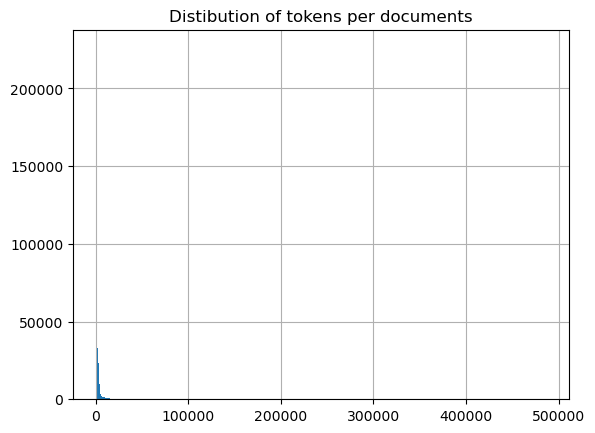

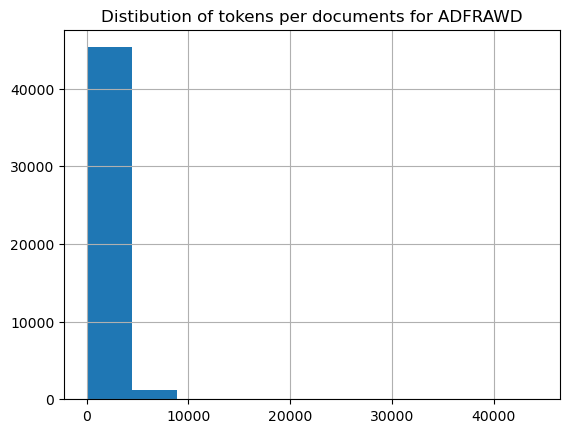

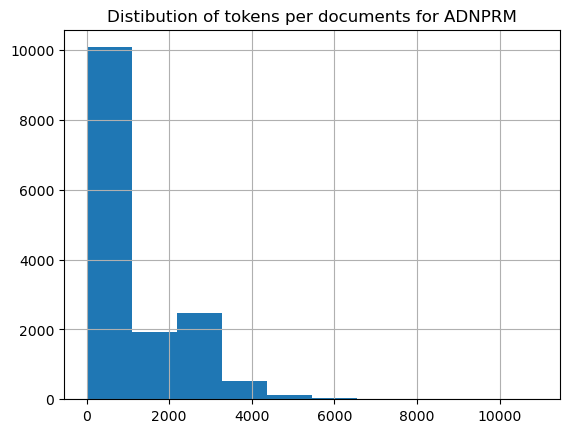

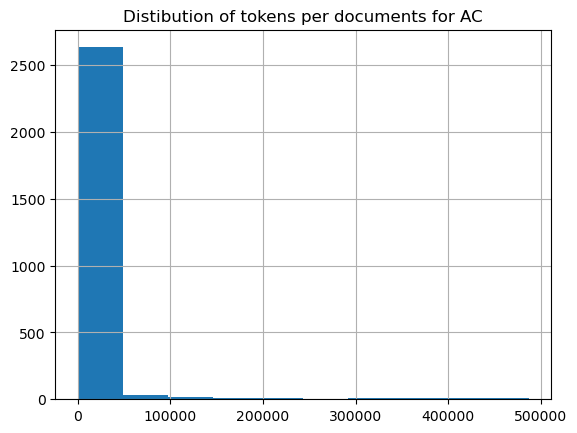

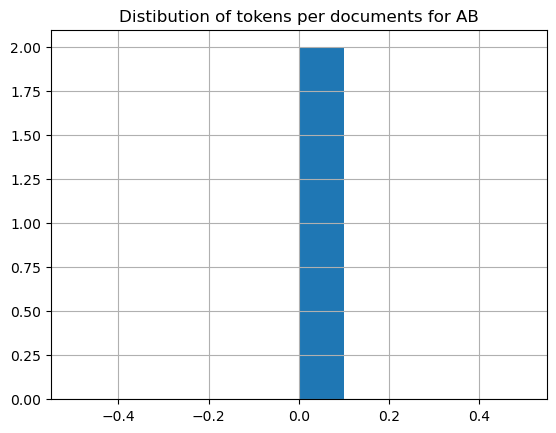

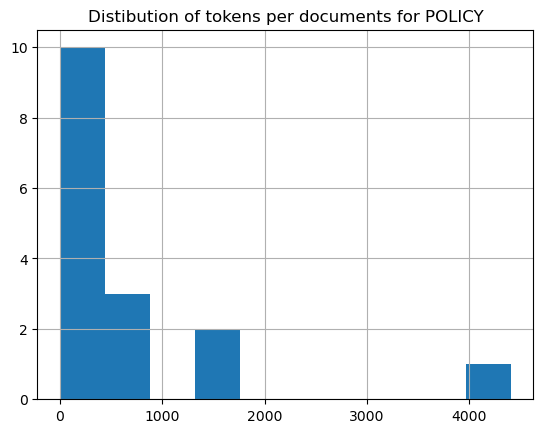

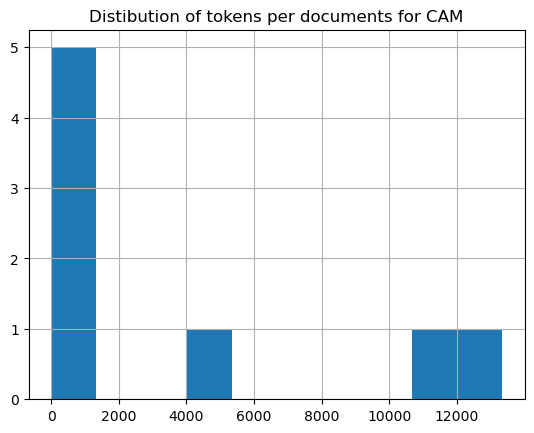

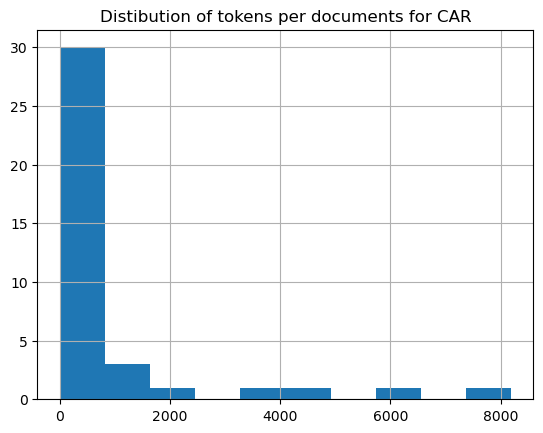

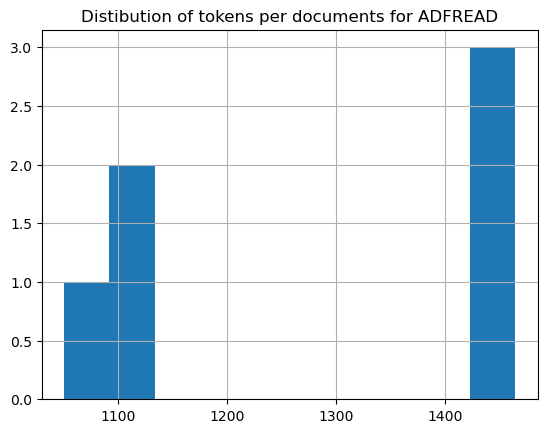

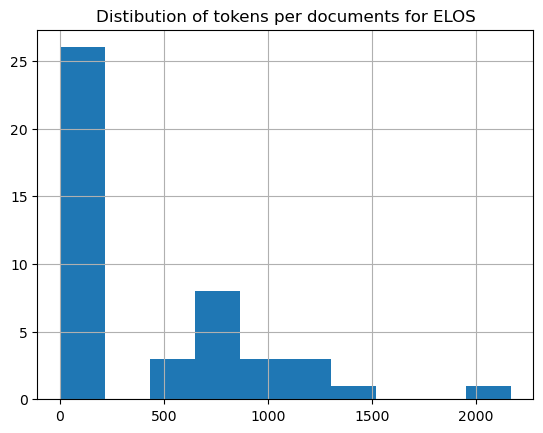

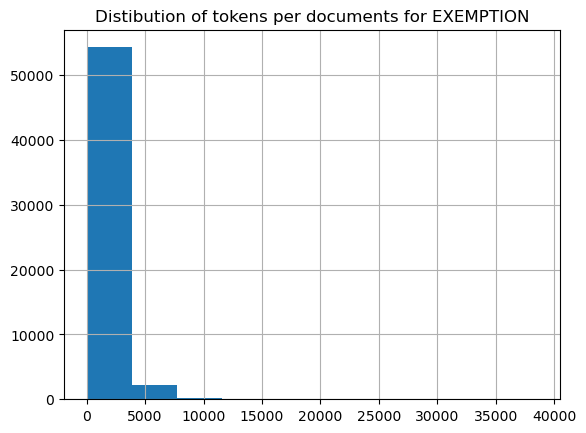

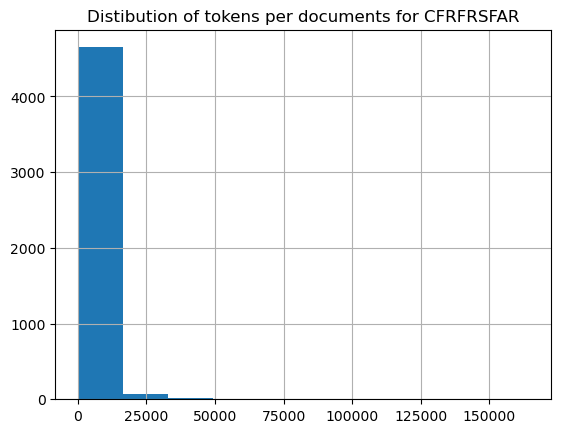

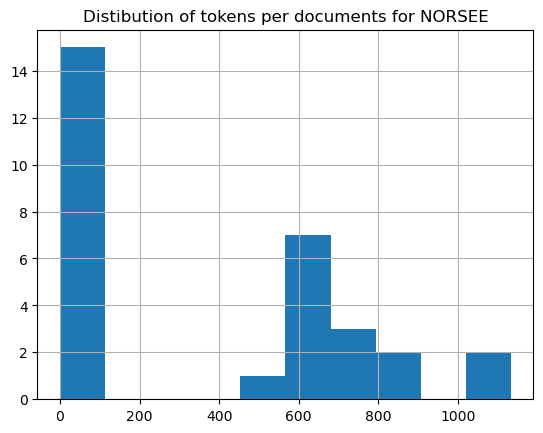

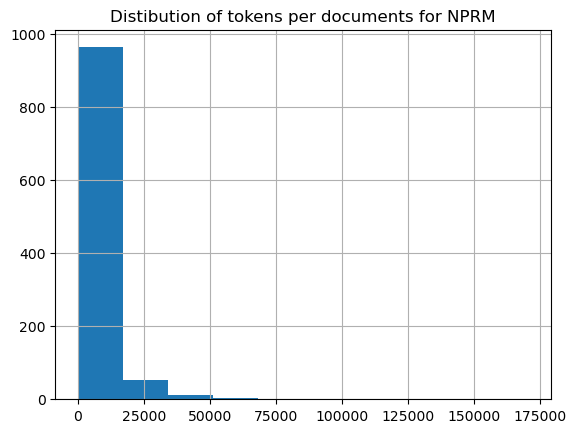

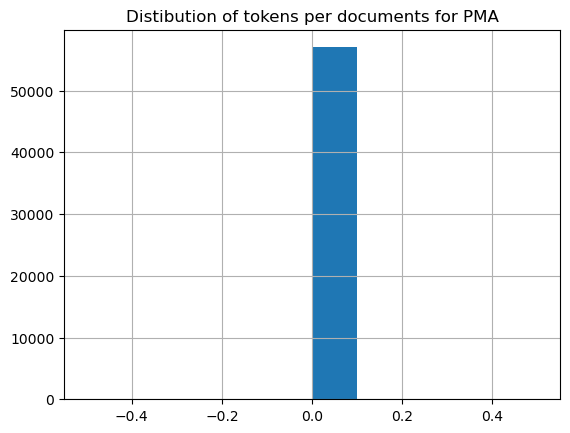

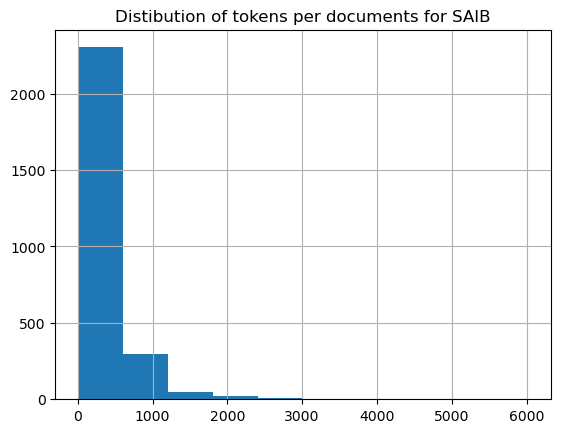

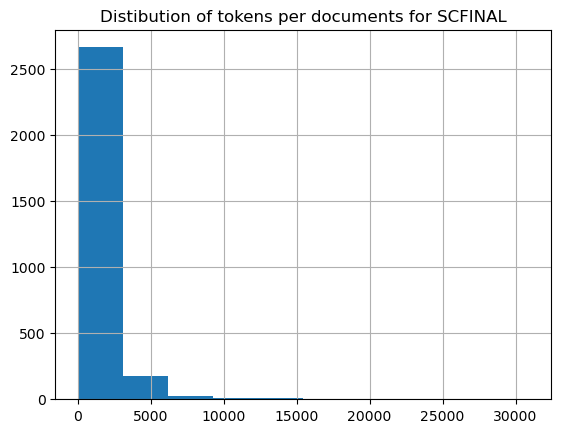

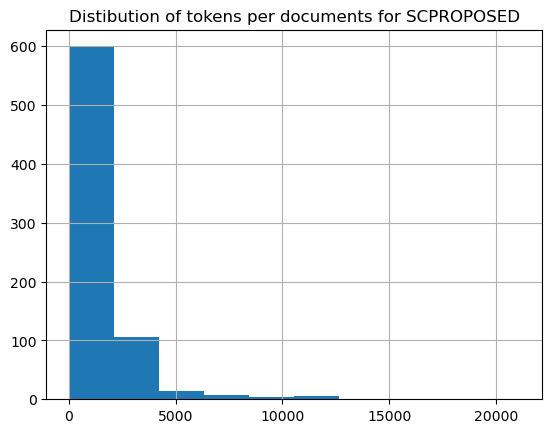

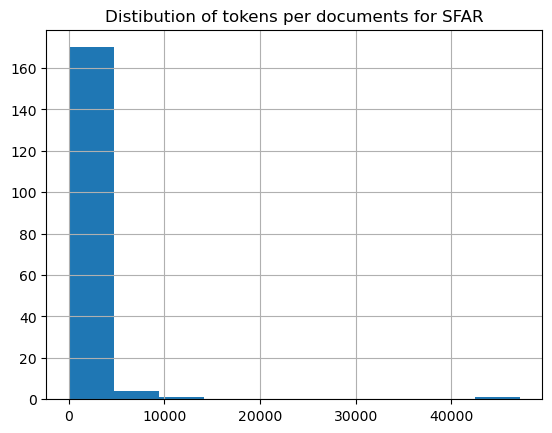

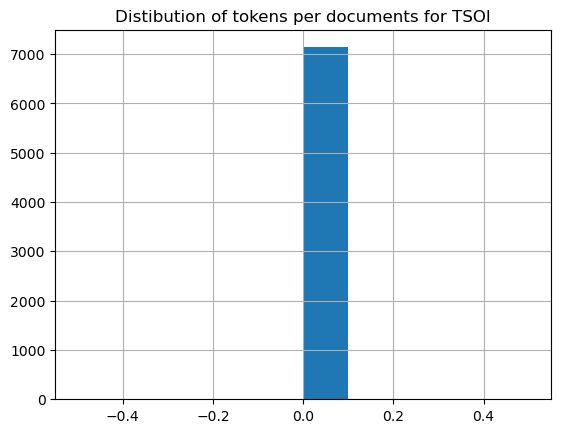

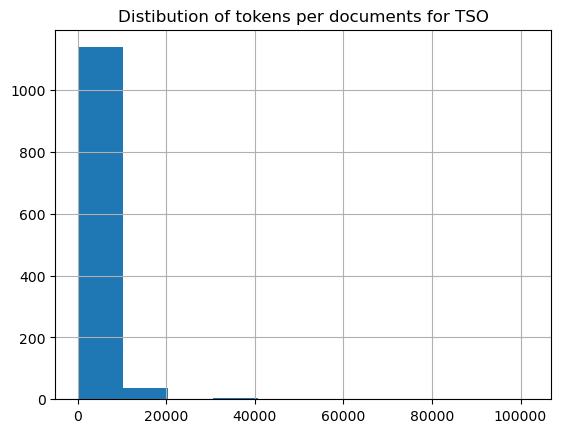

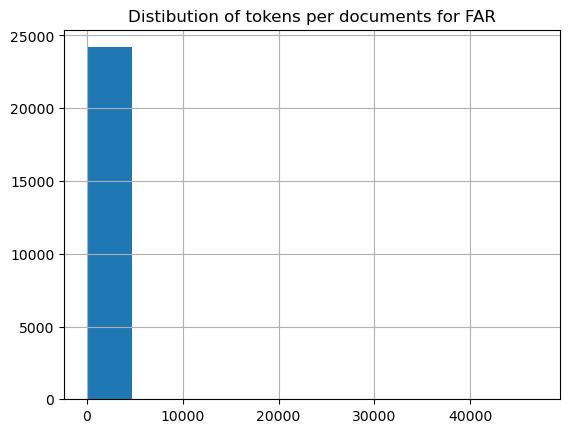

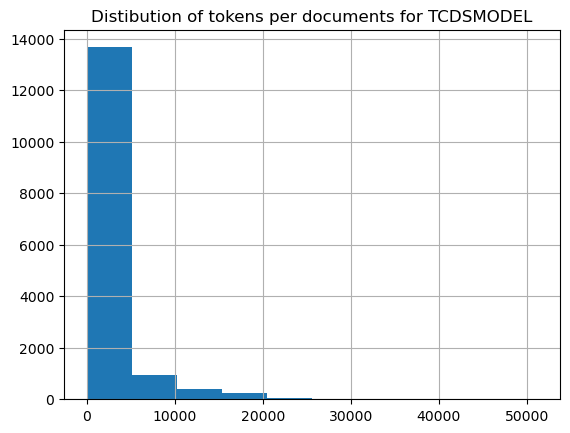

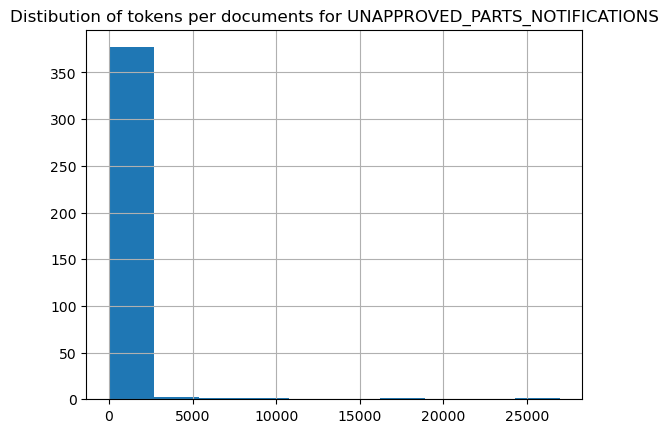

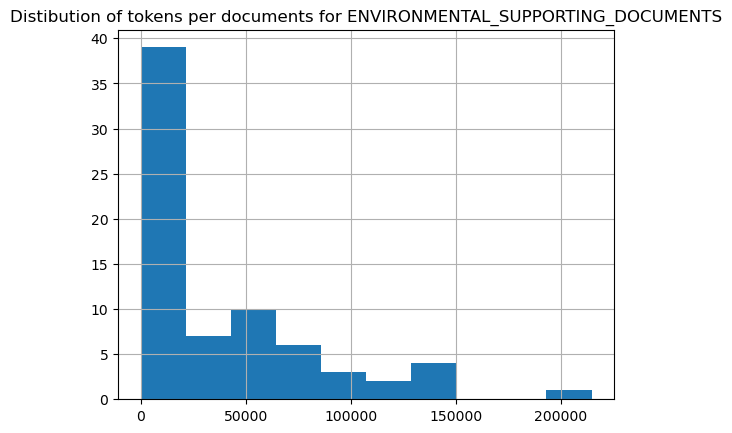

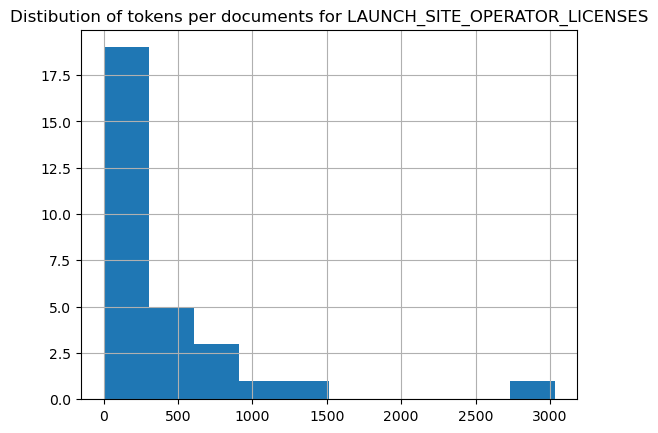

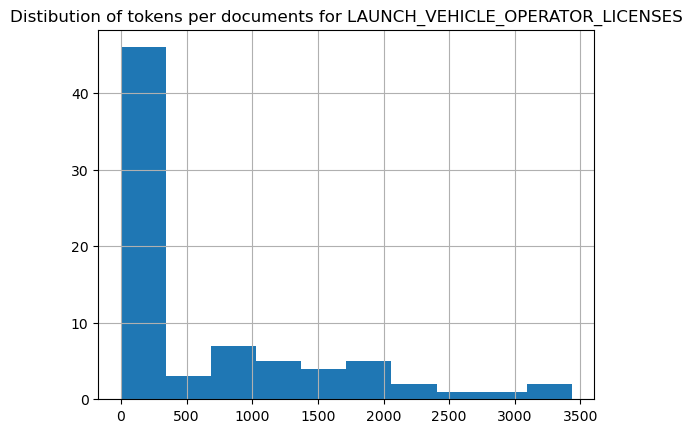

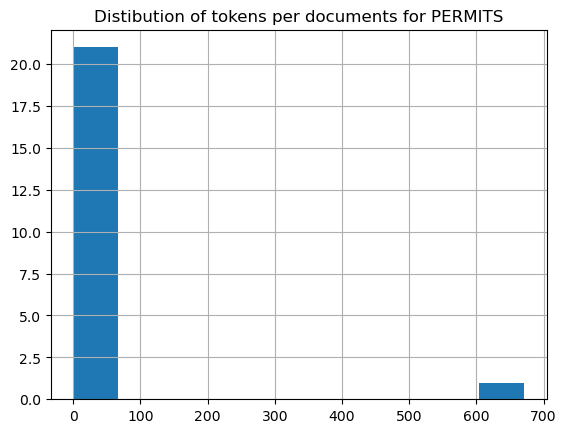

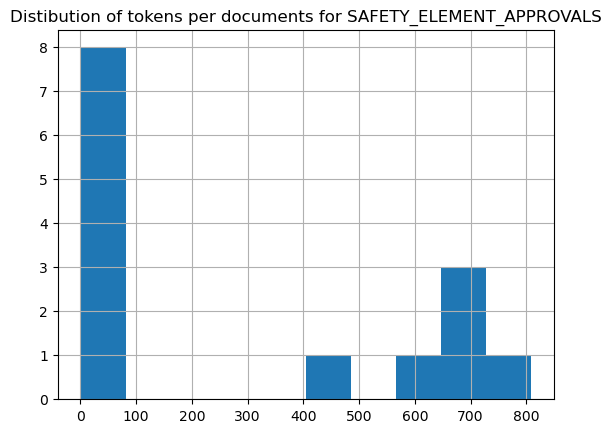

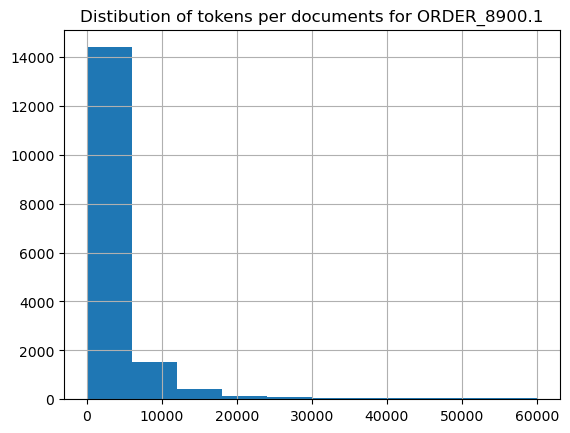

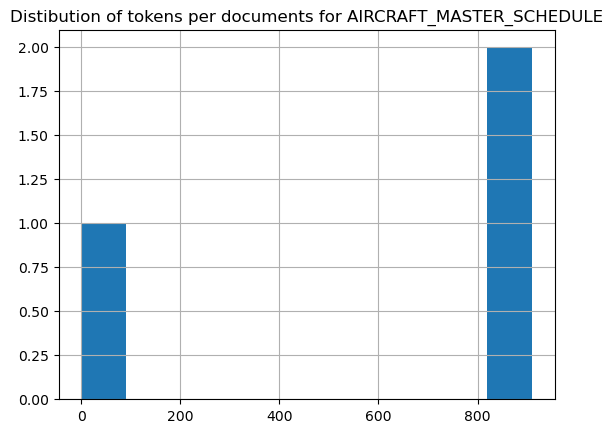

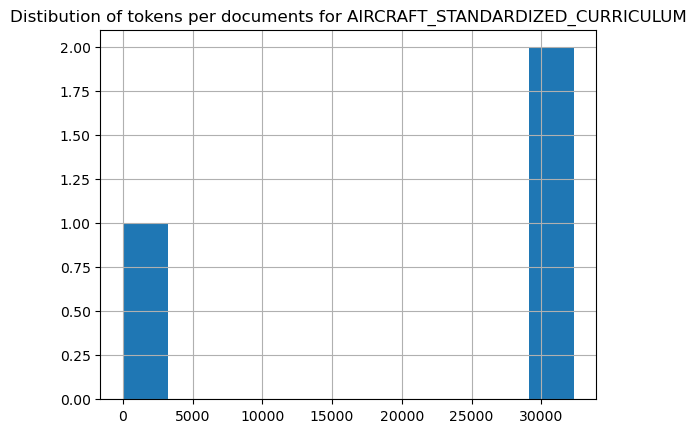

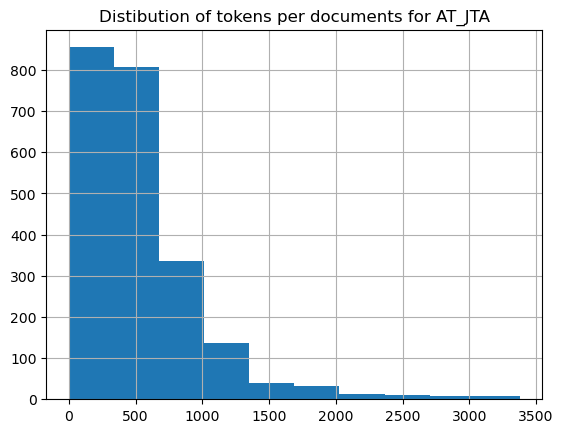

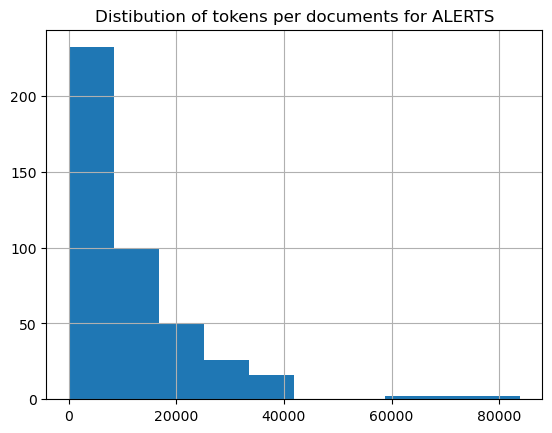

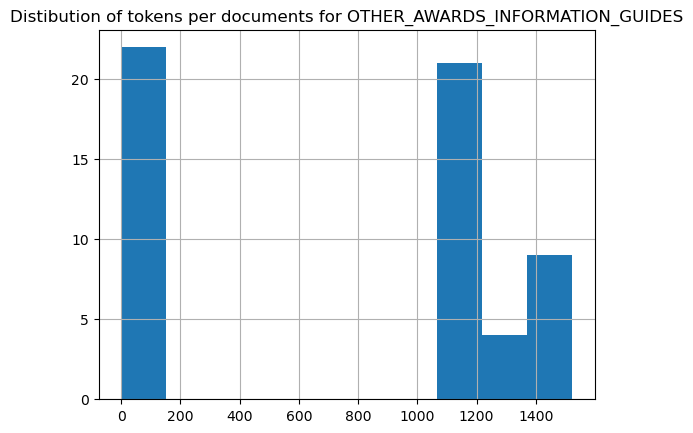

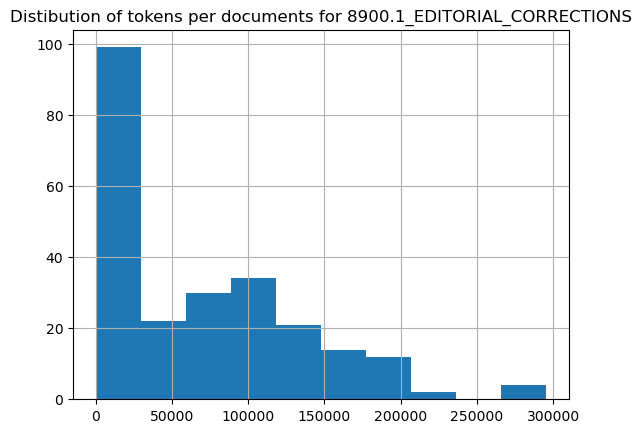

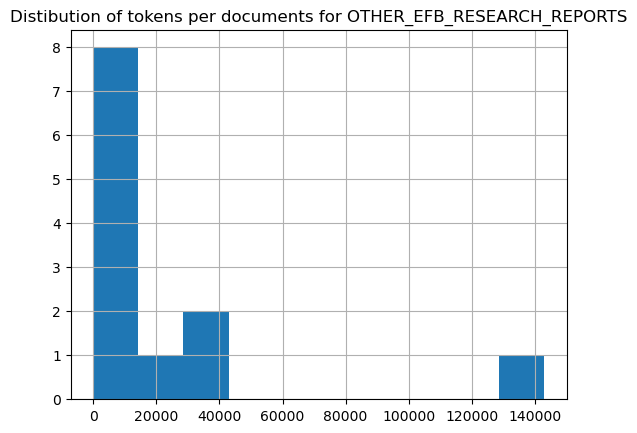

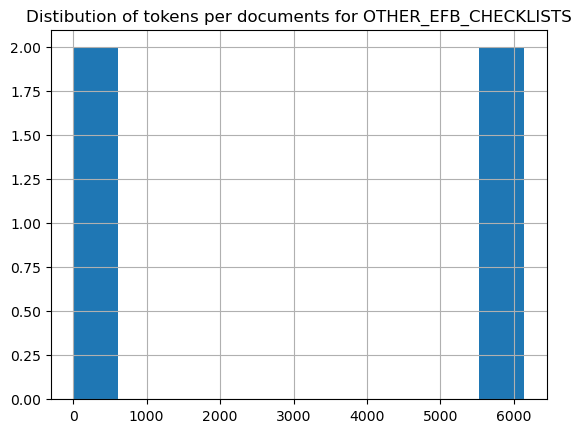

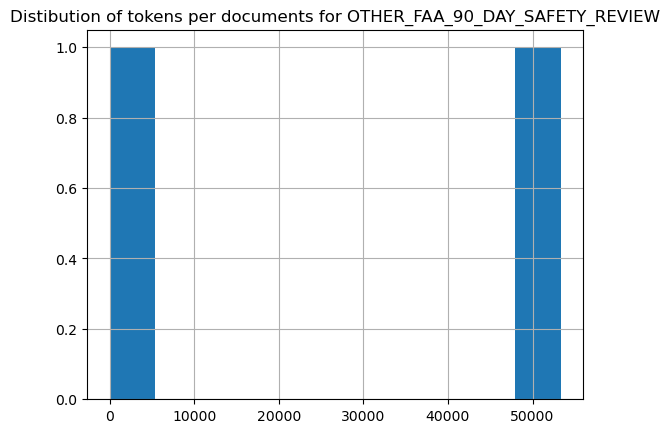

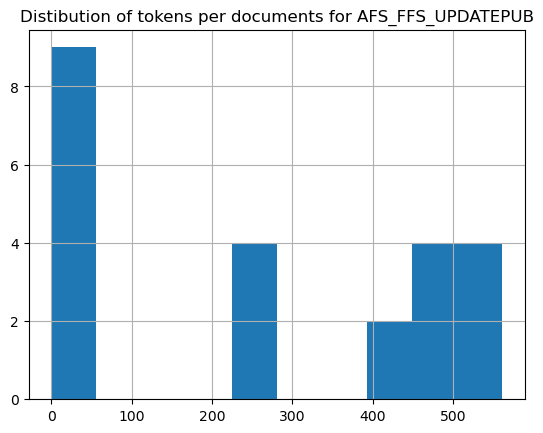

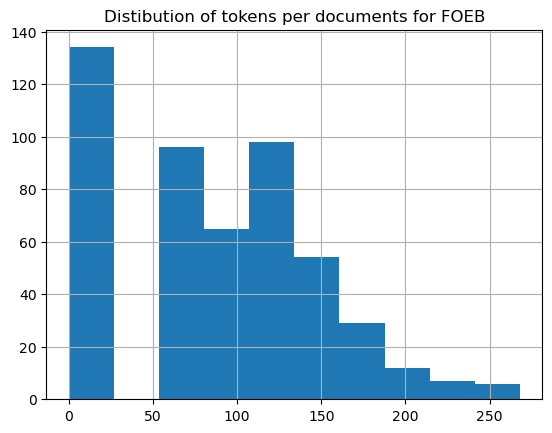

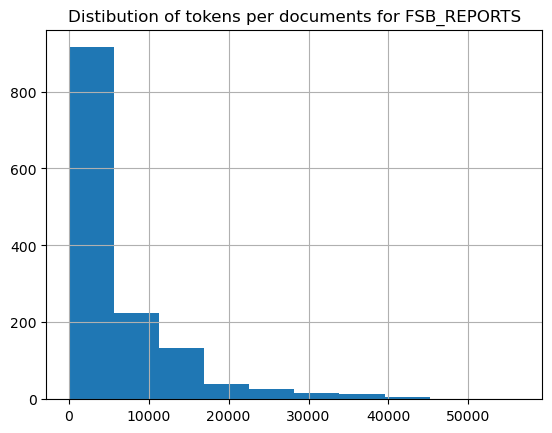

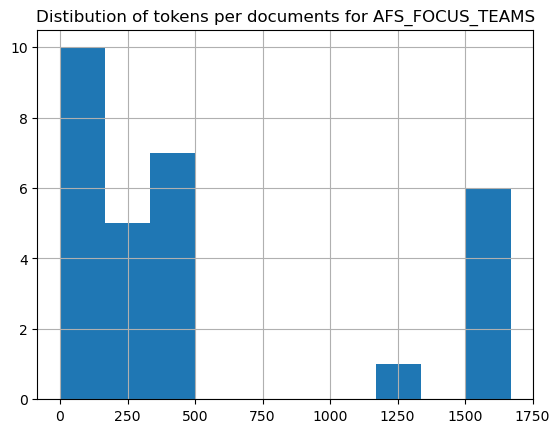

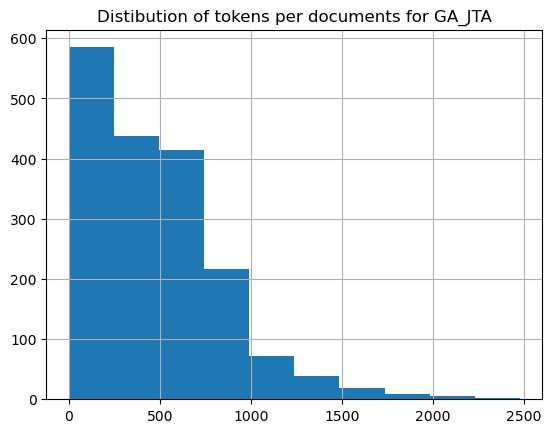

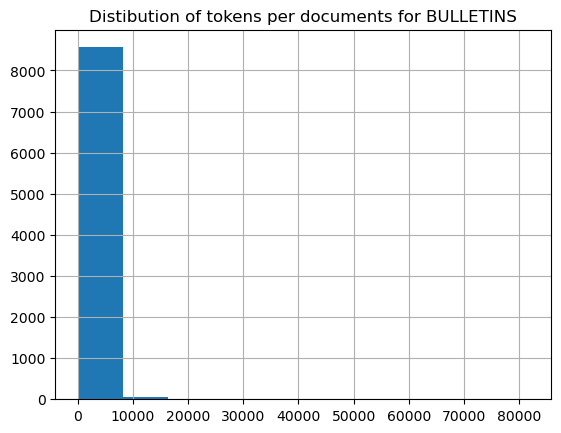

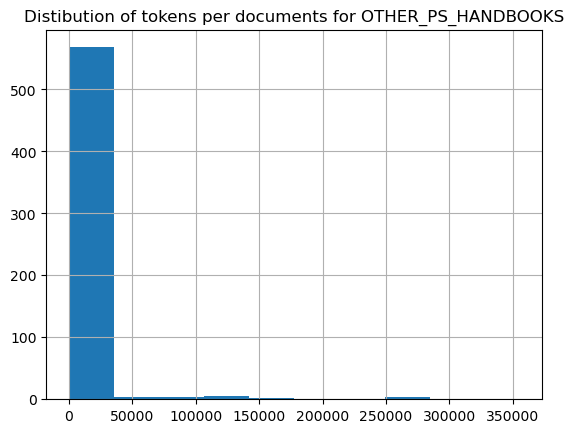

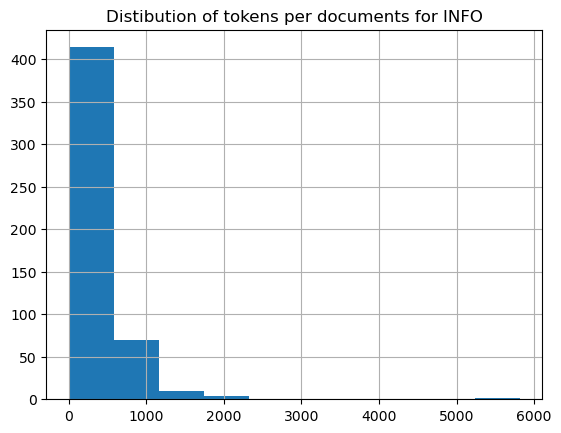

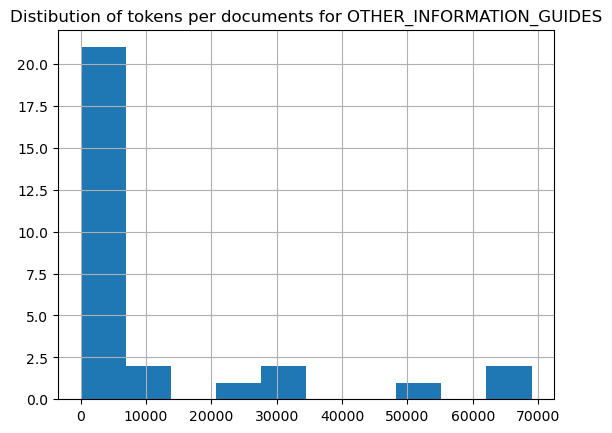

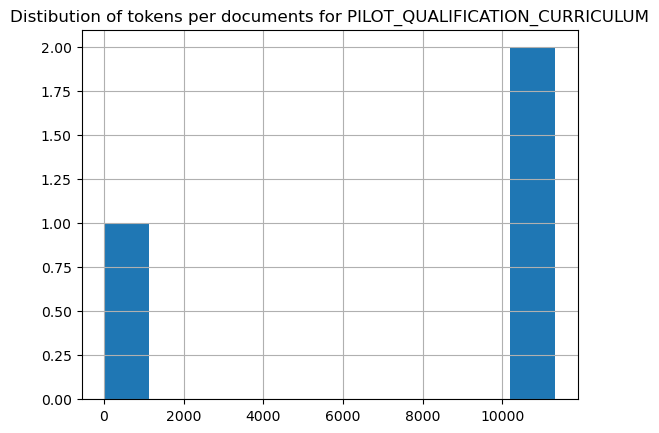

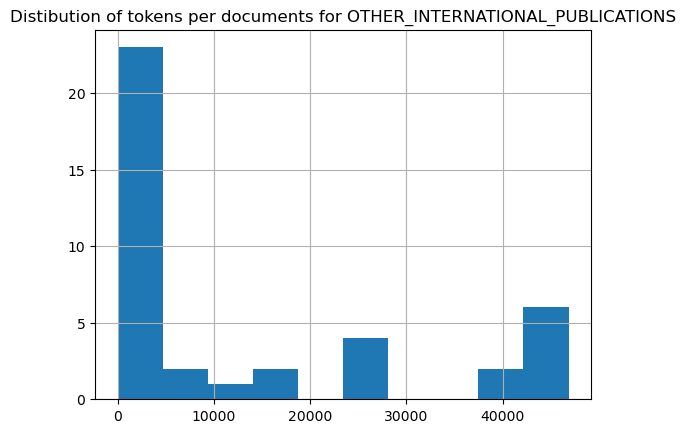

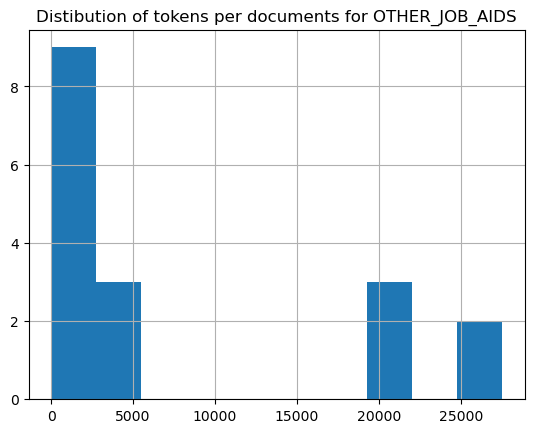

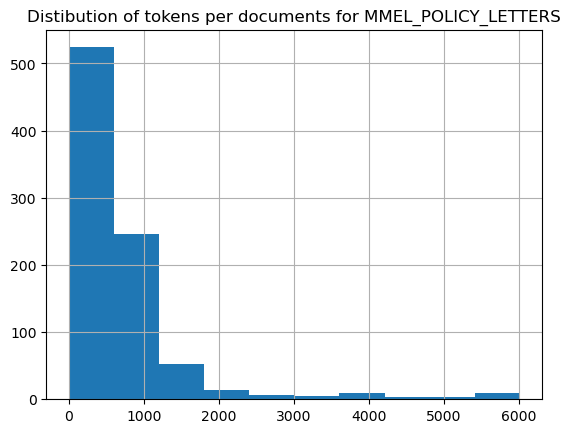

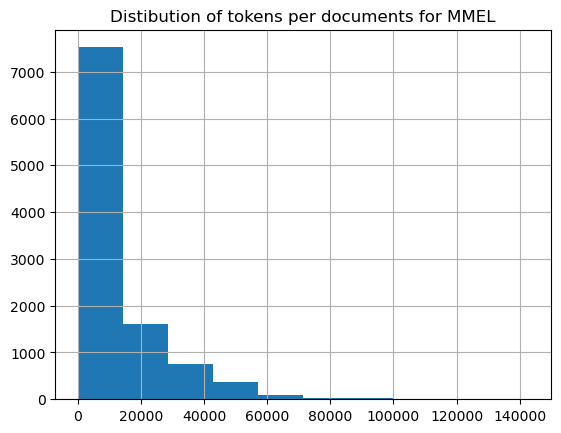

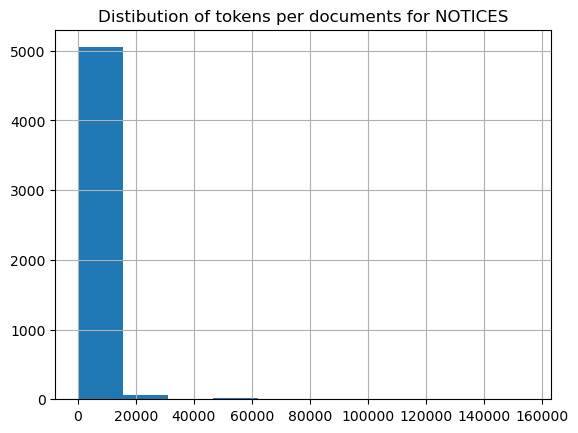

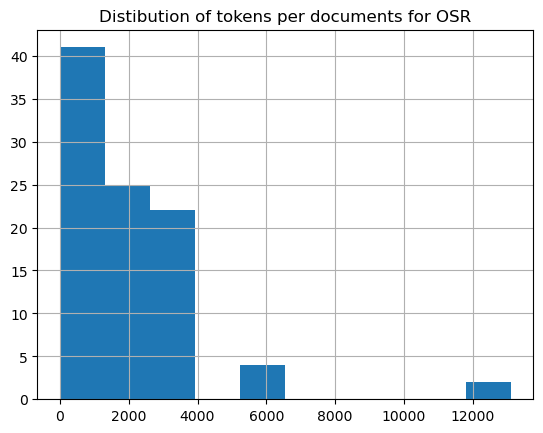

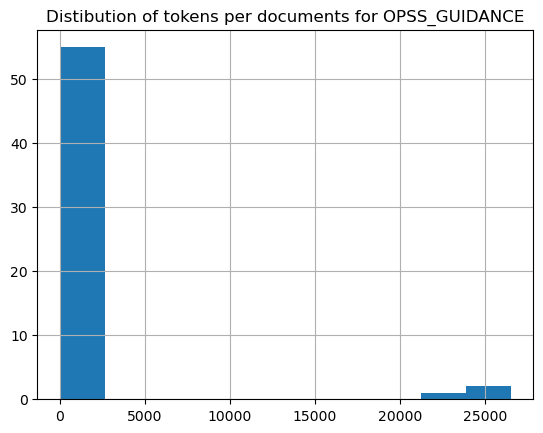

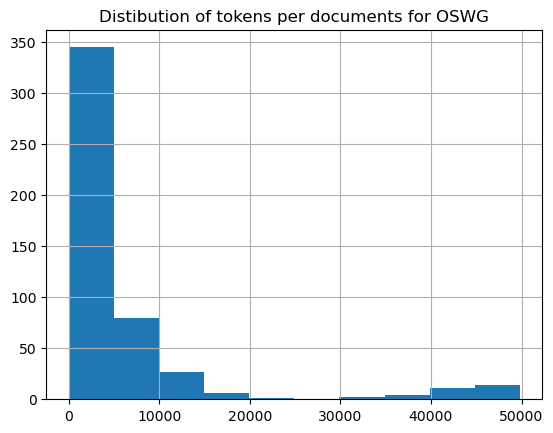

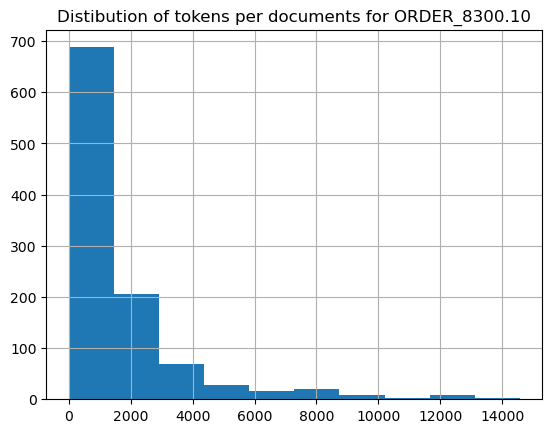

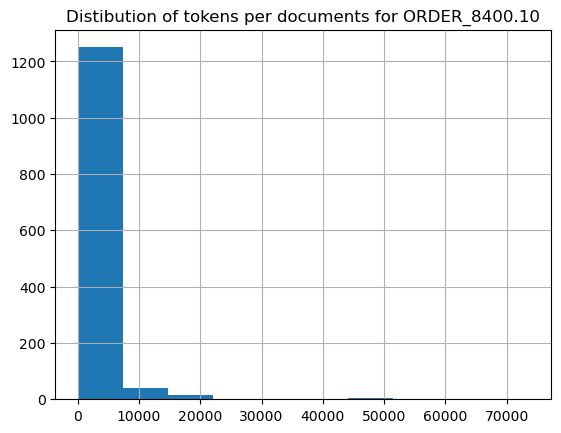

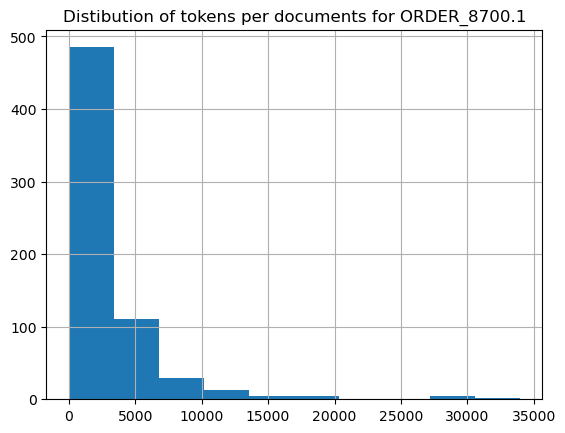

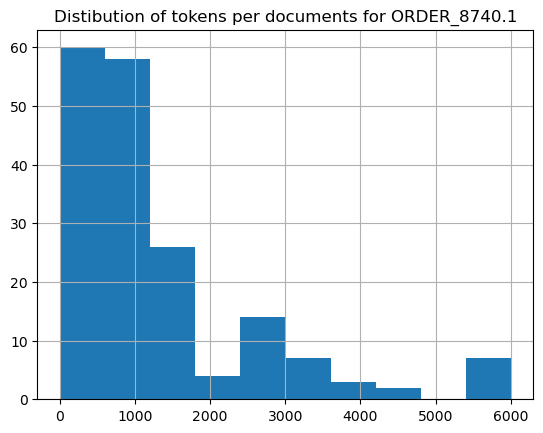

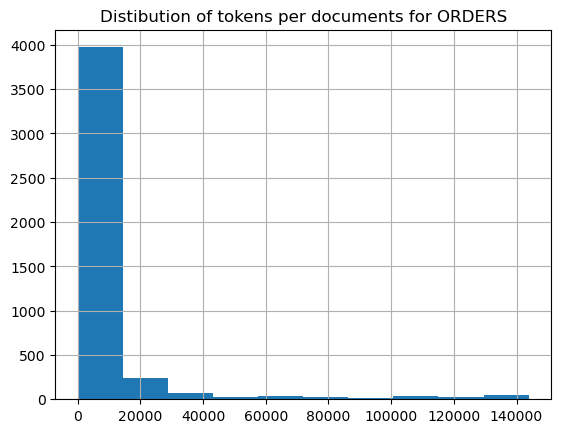

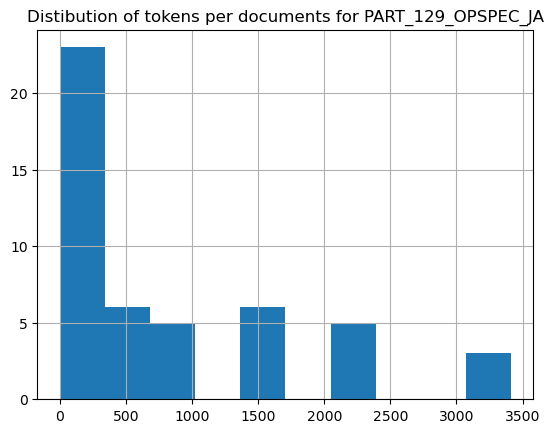

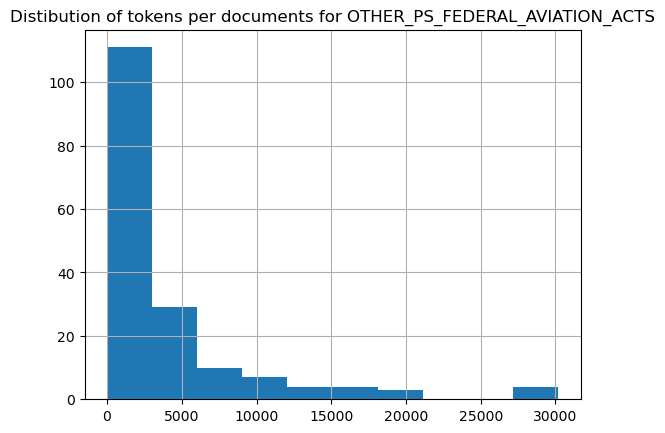

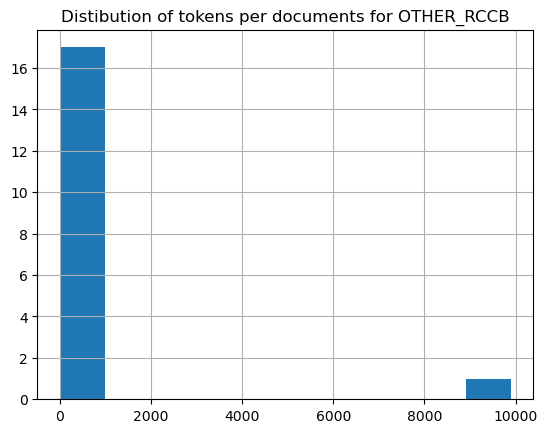

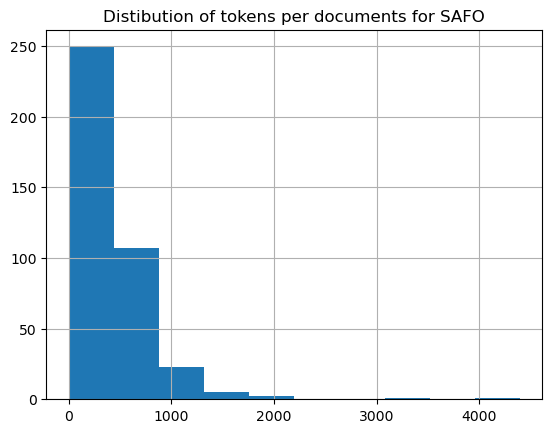

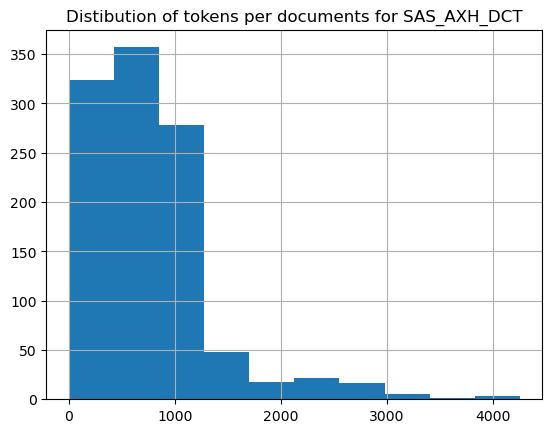

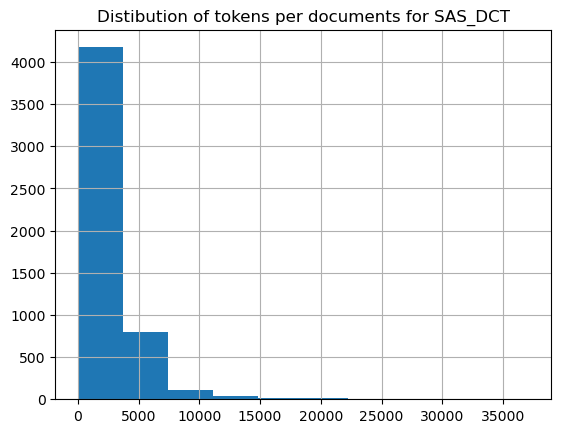

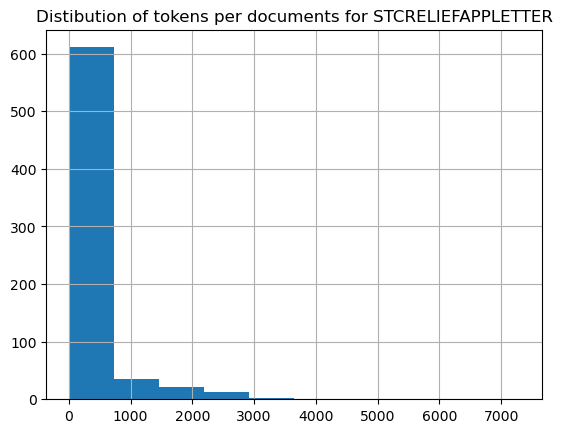

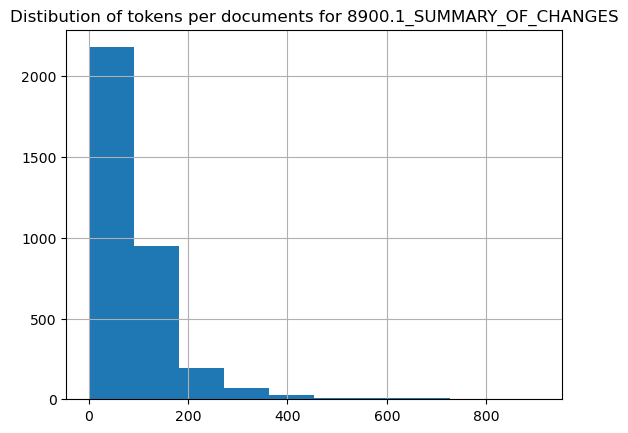

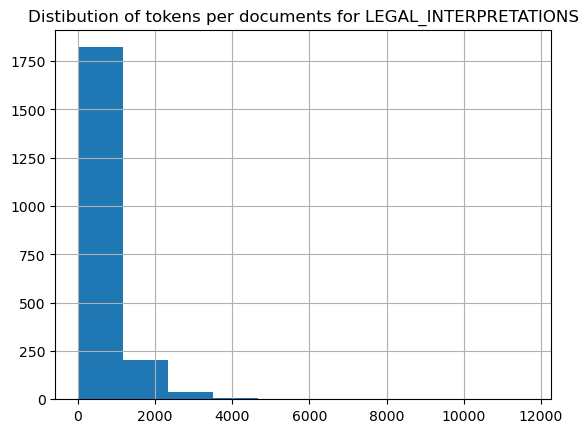

In [7]:
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = 6.4, 4.8

print("Total number of documents = {0}".format(df_drs.shape[0]))
print('-------------------------------')
for doc_type in doc_types:
    print("Number of documents for {0} = {1}".format(doc_type, df_drs[df_drs['doc type']==doc_type].shape[0]))


df_drs['number of tokens'].hist(bins=400)
plt.title("Distibution of tokens per documents")
plt.show()
for doc_type in doc_types:
    if len(df_drs[df_drs['doc type']==doc_type]['number of tokens'])>0:
        df_drs[df_drs['doc type']==doc_type]['number of tokens'].hist()
        plt.title("Distibution of tokens per documents for "+doc_type)
        plt.show()

# .value_counts(ascending=False).nlargest(120).plot.bar()
# plt.title("Number of documents per categories")
# plt.show()
    

# df_stc[content+' totalwords'].hist(bins=400)
# plt.title("Distibution of tokens per documents")
# plt.show()

# for doc_type in doc_types:
#     plt.title("Distibution of tokens per documents for "+doc_type)
#     plt.show()

# plt.title("categories with most documents")
# plt.show()

# df_stc[df_stc["drs:status"].isin(status)]["drs:stcProductSubType"]